# Table of Contents
 <p><div class="lev2"><a href="#EOF-decomposition"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>EOF decomposition</a></div>

In [4]:
%load_ext autoreload
%matplotlib inline

In [5]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from statsmodels.multivariate.pca import PCA

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from plot2D import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [7]:
print()
print("-- define global variables")
print()

print("- choosing options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_stride = '1d'
resolution = '1dx'
daskarray = False
tracktime = True
dates = ('185005010100','185005020000')

for v in ['compset','experiment','member','subset','time_stride','resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define global variables

- choosing options:
compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
time_stride: 1d
resolution: 1dx
daskarray: False
dates: ('185005010100', '185005020000')



In [8]:
if tracktime:
    t0 = time.time()

In [9]:
%%time
print("-- load environment and variables")
print()

historyFilesSettings = getCAMHistoryFilesSettings()
handle = 'h0'
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'

omega,pr,ts,ta,relhum,ps = getValues([omega_id,pr_id,ts_id,ta_id,relhum_id,ps_id],
                                  compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s

-- load environment and variables

Importing OMEGA, PRECT, TS, T, RELHUM, PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
CPU times: user 499 ms, sys: 324 ms, total: 823 ms
Wall time: 1.71 s


In [10]:
print("- compute pressure levels")

input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres = computeP(ps)

cn = getArrayType(pres)

- compute pressure levels


## EOF decomposition

In [91]:
# Compute qvstar
qvstar = saturationSpecificHumidity(temp=ta,pres=pres)

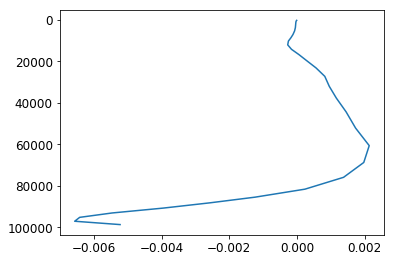

In [117]:
# Domain mean vertical velocity
omega_mean = np.mean(omega,axis=(0,2,3))
qvstar_mean = np.mean(qvstar,axis=(0,2,3))
pres_mean = np.mean(pres,axis=(0,2,3))
fig,ax = plt.subplots()
plt.plot(omega_mean,pres_mean)
ax.invert_yaxis()

In [120]:
levdim=1
nlev = pres.shape[levdim]
pr_for_pca = pr.flatten()
omega_for_pca = np.moveaxis(omega,levdim,-1).reshape((-1,nlev))
omega_for_pca = omega_for_pca - np.vstack([omega_mean]*omega_for_pca.shape[0])
qvstar_for_pca = np.moveaxis(qvstar,levdim,-1).reshape((-1,nlev))
qvstar_for_pca = qvstar_for_pca - np.vstack([qvstar_mean]*qvstar_for_pca.shape[0])
print(pr_for_pca.shape,omega_for_pca.shape,qvstar_for_pca.shape)
# x = np.concatenate([pr_for_pca.reshape((-1,1)),
#                     omega_for_pca,
#                     qvstar_for_pca],axis=1)
x = np.concatenate([omega_for_pca,
                    qvstar_for_pca],axis=1)
print("data shape: ",x.shape)

(4608,) (4608, 30) (4608, 30)
data shape:  (4608, 60)


In [124]:
# weights_for_pcs = np.vstack([pr.flatten()]*nlev)
# weights_for_pcs = pr.flatten()
# stencil = weights_for_pcs>0
# x = omega_for_pca[np.vstack([stencil]*nlev).transpose()].reshape((-1,nlev))
# w = weights_for_pcs[stencil]
print(omega_for_pca.shape,x.shape,weights_for_pcs.shape)

# pc_omega = PCA(x,standardize=False,demean=True,weights=w)
pc_omega = PCA(omega_for_pca,standardize=False,demean=False)

(4608, 30) (4608, 60) (4608,)


In [125]:
pc_omega.eigenvecs[0]

array([ -1.86218106e-05,   2.97810077e-06,   3.21910027e-05,
         7.71841496e-05,   3.10268839e-04,  -1.18801323e-04,
         8.63099910e-05,  -1.39586715e-04,   7.40102957e-04,
        -5.31903839e-04,   4.85122056e-04,  -5.86899940e-04,
         6.26491515e-04,   6.84233433e-05,  -1.11419375e-03,
        -2.15431093e-03,   1.17487715e-03,   1.35432363e-03,
         3.45533966e-03,   8.75277548e-04,   1.75533152e-03,
         3.68640274e-03,   6.58205010e-03,   2.36336037e-03,
         2.40024518e-02,   4.98253989e-02,   1.55816208e-01,
        -5.68619331e-02,  -5.93527822e-01,  -7.85534679e-01])

In [54]:
a = np.linspace(1,10,10).reshape(5,2); print(a); print(a[:,0])
m = (np.random.random(5)>0.5); print(m)
# a[np.reshape([[m]]*2,(2,-1)).transpose()].reshape((-1,2))[:,0]
m2D = np.vstack([m.ravel()]*2).transpose()
print(m2D)
a[m2D].reshape((-1,2))

[[  1.   2.]
 [  3.   4.]
 [  5.   6.]
 [  7.   8.]
 [  9.  10.]]
[ 1.  3.  5.  7.  9.]
[ True False  True False  True]
[[ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]]


array([[  1.,   2.],
       [  5.,   6.],
       [  9.,  10.]])